In [44]:
import requests
import re
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
UserAgent().chrome
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.probability import FreqDist
from nltk.collocations import *
import stanza
stanza.download("es")
nlp_stanza = stanza.Pipeline(lang="es", processors="tokenize, pos, lemma")
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

2025-02-21 22:06:23 INFO: Downloaded file to /Users/elizaveta/stanza_resources/resources.json
2025-02-21 22:06:23 INFO: Downloading default packages for language: es (Spanish) ...
2025-02-21 22:06:24 INFO: File exists: /Users/elizaveta/stanza_resources/es/default.zip
2025-02-21 22:06:27 INFO: Finished downloading models and saved to /Users/elizaveta/stanza_resources
2025-02-21 22:06:27 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-02-21 22:06:27 INFO: Downloaded file to /Users/elizaveta/stanza_resources/resources.json
2025-02-21 22:06:27 WARNING: Language es package default expects mwt, which has been added
2025-02-21 22:06:27 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combine

In [ ]:
# 1 скрейпим все новости всех разделов BBC Mundo и записываем их в отдельные документы txt

amlat_section = 'https://www.bbc.com/mundo/topics/c7zp57yyz25t'
intern_section = 'https://www.bbc.com/mundo/topics/c2lej05epw5t'
festiv_section = 'https://www.bbc.com/mundo/topics/cr50y7p7qyqt'
econ_section = 'https://www.bbc.com/mundo/topics/c06gq9v4xp3t'
cienc_section = 'https://www.bbc.com/mundo/topics/ckdxnw959n7t'
salud_section = 'https://www.bbc.com/mundo/topics/cpzd498zkxgt'
cult_section = 'https://www.bbc.com/mundo/topics/c2dwq9zyv4yt'
tecnolog_section = 'https://www.bbc.com/mundo/topics/cyx5krnw38vt'
sections_links = [amlat_section, intern_section, festiv_section, econ_section, cienc_section, salud_section, cult_section, tecnolog_section]
sections_names = ['amlat_section', 'intern_section', 'festiv_section', 'econ_section', 'cienc_section', 'salud_section', 'cult_section', 'tecnolog_section']

def parser_bbc (link_section):
    result = [] 
    for i in range(1, 41):  
        big_page = requests.get(f'{link_section}?page={i}', headers={'User-Agent': UserAgent().chrome})
        big_page_soup = BeautifulSoup(big_page.text)
        big_page_soup_links = big_page_soup.find_all('a', {'class' : 'bbc-1i4ie53 e1d658bg0'})
        for line in big_page_soup_links:
            line = re.findall(r'href="(.*?)"', str(line)) 
            line = ' '.join(line) # тут получается ссылка на новость в чистом виде
            article_page = requests.get(str(line), headers={'User-Agent': UserAgent().chrome})
            article_page_soup = BeautifulSoup(article_page.text)
            article_page_soup_text = article_page_soup.find_all('p')
            for text in article_page_soup_text:
                a = text.get_text() # собрали секционные тексты в чистом виде
                result.append(a)
    return '\n'.join(result)            


def create_corp(link, name):
    with open(f'{name}.txt', 'w') as file:
        file.write(parser_bbc(link))


for i in range(len(sections_links)):
    create_corp(sections_links[i], sections_names[i])


In [2]:
# 2.1 нормализуем данные: приводим к нижнему регистру и убираем знаки препинания и ненужные символы, а также убираем дублированные в разных рубриках новости
with open('amlat_section.txt', 'r') as file:
    amlat_section_text = file.read()
    
with open('intern_section.txt', 'r') as file:
    intern_section_text = file.read()   
    
with open('festiv_section.txt', 'r') as file:
    festiv_section_text = file.read()    

with open('econ_section.txt', 'r') as file:
    econ_section_text = file.read()   
  
with open('cienc_section.txt', 'r') as file:
    cienc_section_text = file.read()
   
with open('salud_section.txt', 'r') as file:
    salud_section_text = file.read() 
 
with open('cult_section.txt', 'r') as file:
    cult_section_text = file.read()
 
with open('tecnolog_section.txt', 'r') as file:
    tecnolog_section_text = file.read()
    
all_corpus = [amlat_section_text, intern_section_text, festiv_section_text, econ_section_text, cienc_section_text, salud_section_text, cult_section_text, tecnolog_section_text]
all_corpus_clear = []
for each_text in all_corpus:
    each_text = each_text.lower()
    each_text = re.sub('[.,¿?¡!;:/-_-—–$❌✅"()\'´“”©%…*]', ' ', each_text)
    if each_text not in all_corpus_clear:
        all_corpus_clear.append(each_text)

In [3]:
# 2.2 убираем повторяющиеся технические фразы, не связаннные с новостным текстом, и записываем корпус в документ txt

phrases_to_delete = ['fuente de la imagen',  'getty images', 'con reportería del periodista', 'de la bbc', 'haz clic aquí para leer más historias de bbc news mundo', 'suscríbete aquí a nuestro nuevo newsletter para recibir cada viernes una selección de nuestro mejor contenido de la semana', 'también puedes seguirnos en youtube  instagram  tiktok  x  facebook y en nuestro canal de whatsapp ', 'y recuerda que puedes recibir notificaciones en nuestra app', 'descarga la última versión y actívalas', 'la bbc no se hace responsable del contenido de sitios externos', 'lee sobre nuestra postura acerca de enlaces externos', 'con información adicional', 'también puedes seguirnos en youtube  instagram  tiktok  x  facebook y en nuestro nuevo canal de whatsapp', 'epa', 'donde encontrarás noticias de última hora y nuestro mejor contenido', 'reuters', 'descarga la última versión y activarlas', 'haz clic para leer más historias de bbc news mundo', ' bbc news mundo ', 'recuerda que puedes recibir notificaciones', 'descarga la última versión de nuestra app y actívalas para no perderte nuestro mejor contenido', 'ya conoces nuestro canal de youtube', ' suscríbete ', 'descarga la nueva versión de nuestra app y actívalas para no perderte nuestro mejor contenido', 'recuerda que puedes recibir nuestras notificaciones', 'descarga la última versión de la app y actívalas para no perderte nuestro mejor contenido', 'haz clic para leer aquí para más historias', 'haz click aquí para leer más historias de bbc mundo', 'descarga nuestra app y actívalas para no perderte nuestro mejor contenido', 'ahora puedes recibir notificaciones', 'fin del contenido de', 'este artículo contiene contenido proporcionado por', 'solicitamos tu permiso antes de que algo  se cargue  ya que ese sitio', '  puede estar usando cookies y otras tecnologías', 'es posible que quieras leer política de cookies y política de privacidad de twitter antes de aceptar ', 'contenido no disponible', 'para ver este contenido  selecciona  aceptar y continuar', 'es posible que quieras leer política de cookies y política de privacidad de', 'google youtube', 'antes de aceptar', 'ssc', 'afp', 'bbc', 'mundo', 'cortesía', '   ']

all_corpus_clear_unified = ' '.join(all_corpus_clear)
    
for each_phrase in phrases_to_delete:
    all_corpus_clear_unified = all_corpus_clear_unified.replace(each_phrase, '')
    
    with open('all_corpus_clear_unified.txt', 'w') as file:
        file.write(all_corpus_clear_unified)

In [ ]:
# 2.3 убираем стоп-слова, встроенные в nltk + из списка spanish.txt + добавленные по нашему усмотрению и запишем чистый корпус в отдельный документ txt

all_corpus_clear_unified = word_tokenize(all_corpus_clear_unified)

with open('spanish.txt', 'r') as extra_stop:
    extra_stop = extra_stop.read()
    extra_stop = extra_stop.replace('\n', ' ')
    extra_stop = extra_stop.split()

all_stopwords = extra_stop + stopwords.words('spanish') + ['u', 'e', 'hacía', 'aunque', 'así', 'si', 'según', 'ello', 'cómo', 'uno', 'incluso']

tokens_no_stop = [token for token in all_corpus_clear_unified if token not in all_stopwords]

# 3259096 токенов во всём корпусе без стоп-слов
print(len(tokens_no_stop)) 

with open('tokens_no_stop.txt', 'w') as file:
        file.write(str(tokens_no_stop))

3259096


[('años', 17404), ('personas', 11621), ('país', 8698), ('vida', 8520), ('año', 6687), ('forma', 6136), ('unidos', 6035), ('gente', 5885), ('gobierno', 5766), ('millones', 5640), ('países', 5088), ('día', 4961), ('mujeres', 4872), ('historia', 4681), ('universidad', 4580), ('trump', 4399), ('ee', 4263), ('salud', 4242), ('china', 4058), ('ciudad', 3897), ('tipo', 3852), ('guerra', 3844), ('sistema', 3792), ('casa', 3773), ('presidente', 3743), ('caso', 3705), ('importante', 3642), ('us', 3597), ('días', 3558), ('persona', 3521), ('empresa', 3509), ('familia', 3320), ('cambio', 3246), ('libro', 3189), ('mayoría', 3185), ('uu', 3135), ('investigación', 3110), ('grupo', 3089), ('agua', 3085), ('empresas', 3046), ('méxico', 3024), ('problemas', 2939), ('datos', 2913), ('meses', 2893), ('política', 2873), ('niños', 2840), ('estadounidense', 2798), ('economía', 2792), ('seguridad', 2784), ('idea', 2757), ('medio', 2755), ('dinero', 2751), ('reino', 2715), ('realmente', 2697), ('cuerpo', 2695)

<Axes: title={'center': 'Топ-25 слов'}, xlabel='Samples', ylabel='Counts'>

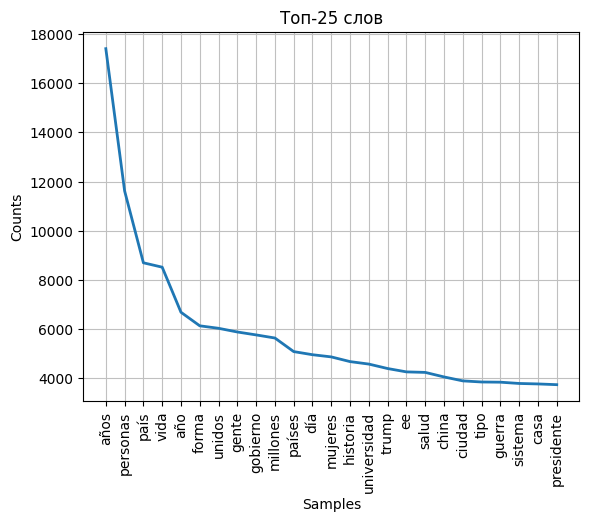

In [5]:
# 3.1 самые частотные слова во всем корпусе новостей без стоп-слов (на всякий случай и с помощью Counter, и с помощью FreqDist, + создаём график)

counter_no_stop = Counter(tokens_no_stop)
print(counter_no_stop.most_common(1000))

frequencies = FreqDist(tokens_no_stop)
print(frequencies.most_common(25))

frequencies.plot(25, title = 'Топ-25 слов')

In [ ]:
# 3.2 топ-200 частотных биграмм во всем корпусе новостей без стоп-слов

bigram_measures = nltk.collocations.BigramAssocMeasures()
finder_big = BigramCollocationFinder.from_words(tokens_no_stop)
finder_big.nbest(bigram_measures.raw_freq, 200)

[('ee', 'uu'),
 ('reino', 'unido'),
 ('us', 'millones'),
 ('redes', 'sociales'),
 ('américa', 'latina'),
 ('inteligencia', 'artificial'),
 ('donald', 'trump'),
 ('cambio', 'climático'),
 ('casa', 'blanca'),
 ('salud', 'mental'),
 ('millones', 'personas'),
 ('derechos', 'humanos'),
 ('corea', 'sur'),
 ('director', 'ejecutivo'),
 ('siglas', 'inglés'),
 ('guerra', 'mundial'),
 ('siglo', 'xx'),
 ('naciones', 'unidas'),
 ('siglo', 'xix'),
 ('haz', 'clic'),
 ('punto', 'vista'),
 ('versión', 'original'),
 ('joe', 'biden'),
 ('sitio', 'web'),
 ('red', 'social'),
 ('artículo', 'publicado'),
 ('elon', 'musk'),
 ('medio', 'oriente'),
 ('unión', 'europea'),
 ('leer', 'versión'),
 ('seres', 'humanos'),
 ('the', 'conversation'),
 ('miles', 'millones'),
 ('millones', 'años'),
 ('corea', 'norte'),
 ('millones', 'dólares'),
 ('medio', 'ambiente'),
 ('pandemia', 'covid'),
 ('crecimiento', 'económico'),
 ('banco', 'central'),
 ('tasas', 'interés'),
 ('presidente', 'electo'),
 ('new', 'york'),
 ('clic', '

In [7]:
# 3.3 попробуем взять несколько метрик для подсчета частотных биграмм и сложим их ранги
scores_lhr = finder_big.score_ngrams(bigram_measures.likelihood_ratio)
scores_raw = finder_big.score_ngrams(bigram_measures.student_t)

rank_raw = []
counter = 1
for colloc in scores_raw:
    rank_raw.append((colloc[0], counter))
    counter += 1
    
rank_lhr = []
counter = 1
for colloc in scores_lhr:
    rank_lhr.append((colloc[0], counter))
    counter += 1

all_ranks = [rank_lhr, rank_raw]
sum_of_ranks = {}
for bigs_ranks in all_ranks:
    bigs, ranks = zip(*bigs_ranks)
    for index in range(len(ranks)):
        if bigs[index] not in sum_of_ranks:
            sum_of_ranks[bigs[index]] = 0
        sum_of_ranks[bigs[index]] += ranks[index]

sum_of_ranks

{('ee', 'uu'): 2,
 ('reino', 'unido'): 4,
 ('redes', 'sociales'): 7,
 ('américa', 'latina'): 9,
 ('us', 'millones'): 8,
 ('inteligencia', 'artificial'): 12,
 ('donald', 'trump'): 14,
 ('cambio', 'climático'): 16,
 ('casa', 'blanca'): 18,
 ('haz', 'clic'): 30,
 ('salud', 'mental'): 21,
 ('naciones', 'unidas'): 30,
 ('director', 'ejecutivo'): 27,
 ('siglas', 'inglés'): 29,
 ('siglo', 'xx'): 32,
 ('corea', 'sur'): 29,
 ('elon', 'musk'): 44,
 ('siglo', 'xix'): 37,
 ('joe', 'biden'): 42,
 ('derechos', 'humanos'): 32,
 ('unión', 'europea'): 50,
 ('the', 'conversation'): 53,
 ('sitio', 'web'): 47,
 ('versión', 'original'): 46,
 ('creative', 'commons'): 78,
 ('medio', 'oriente'): 54,
 ('silicon', 'valley'): 85,
 ('artículo', 'publicado'): 54,
 ('punto', 'vista'): 50,
 ('leer', 'versión'): 60,
 ('combustibles', 'fósiles'): 79,
 ('seres', 'humanos'): 64,
 ('red', 'social'): 58,
 ('licencia', 'creative'): 88,
 ('guerra', 'mundial'): 51,
 ('hong', 'kong'): 130,
 ('escritores', 'pensadores'): 102,


In [ ]:
# 4.1 экономические тексты: предобработка и создание txt (537299 токенов без стоп-слов)

econ_section_text = re.sub('[.,¿?¡!;:/-_-—–$❌✅"()\'“”©%]', ' ', econ_section_text.lower())
for each_phrase in phrases_to_delete:
    econ_section_text = econ_section_text.replace(each_phrase, '')
econ_tokens = word_tokenize(econ_section_text)

econ_tokens_no_stop = [econtoken for econtoken in econ_tokens if econtoken not in all_stopwords]

econ_tokens_no_stop_for_doc = ' '.join(econ_tokens_no_stop)
with open('econ_tokens_no_stop.txt', 'w') as new_econ_file:
    new_econ_file.write(econ_tokens_no_stop_for_doc)

[('país', 3155), ('años', 2703), ('gobierno', 2072), ('economía', 1792), ('año', 1747), ('millones', 1741), ('países', 1671), ('china', 1593), ('us', 1537), ('personas', 1442), ('unidos', 1397), ('empresas', 1319), ('empresa', 1117), ('presidente', 1091), ('dinero', 1040), ('ee', 986), ('política', 971), ('precios', 961), ('mercado', 955), ('vida', 907), ('inflación', 881), ('gente', 837), ('crisis', 834), ('crecimiento', 809), ('méxico', 774)]


<Axes: title={'center': 'Топ-25 слов'}, xlabel='Samples', ylabel='Counts'>

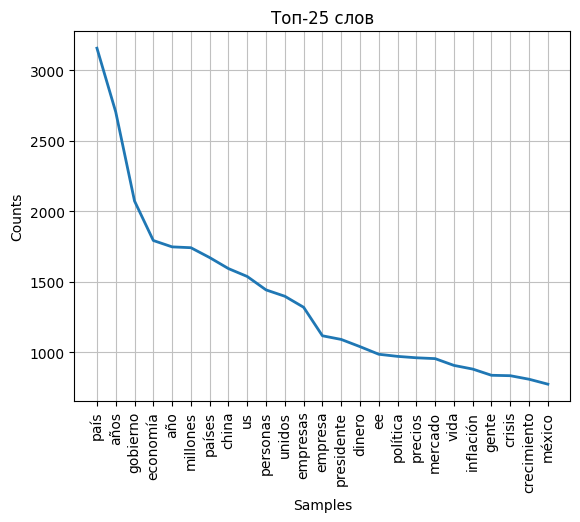

In [ ]:
# 4.2 экономические тексты: самые частотные слова + график

frequencies = FreqDist(econ_tokens_no_stop)
print(frequencies.most_common(25))


frequencies.plot(25, title = 'Топ-25 слов')

In [10]:
# 4.3 экономические тексты: самая частотная часть речи среди топ-250 частотных слов -- существительные (больше половины: 154 из 250)
econ_common_words = []

for pair in frequencies.most_common(250):
    econ_common_words.append(pair[0])
    
econ_freq_doc = nlp_stanza(' '.join(econ_common_words))
econ_stanza_nouns = [word.lemma for t in econ_freq_doc.iter_tokens() for word in t.words if word.upos == 'NOUN']
print(len(econ_stanza_nouns))
print(econ_stanza_nouns)

154
['país', 'año', 'gobierno', 'economía', 'año', 'millón', 'país', 'persona', 'empresa', 'empresa', 'presidente', 'dinero', 'política', 'mercado', 'vida', 'inflación', 'gente', 'crisis', 'crecimiento', 'trabajador', 'cambio', 'forma', 'aumento', 'producto', 'banco', 'guerra', 'sistema', 'ciudad', 'mayoría', 'población', 'sector', 'acuerdo', 'precio', 'universidad', 'mes', 'región', 'dato', 'tipo', 'petróleo', 'día', 'medida', 'producción', 'industria', 'energía', 'situación', 'historia', 'problema', 'nivel', 'seguridad', 'caso', 'casa', 'día', 'problema', 'interés', 'pandemia', 'dólar', 'experto', 'reino', 'medida', 'ingreso', 'década', 'gas', 'desarrollo', 'centro', 'comercio', 'década', 'mujer', 'deuda', 'ley', 'inversión', 'compañía', 'costo', 'tecnología', 'grupo', 'política', 'alimento', 'autoridad', 'servicio', 'punto', 'capital', 'tasa', 'moneda', 'número', 'norte', 'proyecto', 'banco', 'impacto', 'semana', 'recurso', 'profesor', 'director', 'mercado', 'idea', 'cliente', 'ries

In [ ]:
# 4.4 экономические тексты: частотные биграммы с указанием рангов 

finder_big_econ = BigramCollocationFinder.from_words(econ_tokens_no_stop)

scores_raw_econ = finder_big_econ.score_ngrams(bigram_measures.student_t)
rank_raw_econ = []
counter = 1
for colloc in scores_raw_econ:
    rank_raw_econ.append((colloc[0], counter))
    counter += 1

In [13]:
# 4.5 шаблоны биграмм с учетом частей речи: 

# выделяем части речи с помощью Stanza
first_elem_econ = []
second_elem_econ = []
for i in range(len(rank_raw_econ)):
    first_elem_econ.append(rank_raw_econ[i][0][0])
    second_elem_econ.append(rank_raw_econ[i][0][1])
    
first_list_econ = nlp_stanza(' '.join(first_elem_econ[:1000]))
second_list_econ = nlp_stanza(' '.join(second_elem_econ[:1000]))

first_lemmas_econ = [word.upos for t in first_list_econ.iter_tokens() for word in t.words]
second_lemmas_econ = [word.upos for t in second_list_econ.iter_tokens() for word in t.words]

bigrams_lemmas_econ = []
for i in range(len(first_lemmas_econ)-1):
    bigrams_lemmas_econ.append((first_lemmas_econ[i], second_lemmas_econ[i]))
print(bigrams_lemmas_econ) 


# подсчитываем количество биграмм в каждом шаблоне
num_elem_NOUN_ADJ = []
num_elem_ADJ_NOUN = []
num_elem_NOUN_VERB = []
num_elem_VERB_NOUN = []
num_elem_VERB_ADJ = []
num_elem_ADJ_VERB = []
for i in range(len(first_lemmas_econ)-1):
    if re.match(r'NOUN', bigrams_lemmas_econ[i][0]) and re.match(r'ADJ', bigrams_lemmas_econ[i][1]):
        num_elem_NOUN_ADJ.append(i)
    if re.match(r'ADJ', bigrams_lemmas_econ[i][0]) and re.match(r'NOUN', bigrams_lemmas_econ[i][1]):
        num_elem_ADJ_NOUN.append(i)
    if re.match(r'NOUN', bigrams_lemmas_econ[i][0]) and re.match(r'VERB', bigrams_lemmas_econ[i][1]):
        num_elem_NOUN_VERB.append(i)
    if re.match(r'VERB', bigrams_lemmas_econ[i][0]) and re.match(r'NOUN', bigrams_lemmas_econ[i][1]):
        num_elem_VERB_NOUN.append(i)
    if re.match(r'VERB', bigrams_lemmas_econ[i][0]) and re.match(r'ADJ', bigrams_lemmas_econ[i][1]):
        num_elem_VERB_ADJ.append(i)
    if re.match(r'ADJ', bigrams_lemmas_econ[i][0]) and re.match(r'VERB', bigrams_lemmas_econ[i][1]):
        num_elem_ADJ_VERB.append(i)
    
print(len(num_elem_NOUN_ADJ), len(num_elem_ADJ_NOUN), len(num_elem_NOUN_VERB), len(num_elem_VERB_NOUN), len(num_elem_VERB_ADJ), len(num_elem_ADJ_VERB)) 

# собираем вместе биграммы по шаблонам с указанием ранга
NOUN_ADJ = []
for num in num_elem_NOUN_ADJ:
    NOUN_ADJ.append(rank_raw_econ[num])
print(NOUN_ADJ)

ADJ_NOUN = []
for num in num_elem_ADJ_NOUN:
    ADJ_NOUN.append(rank_raw_econ[num])
print(ADJ_NOUN)

NOUN_VERB = []
for num in num_elem_NOUN_VERB:
    NOUN_VERB.append(rank_raw_econ[num])
print(NOUN_VERB)

VERB_NOUN = []
for num in num_elem_VERB_NOUN:
    VERB_NOUN.append(rank_raw_econ[num])
print(VERB_NOUN)

VERB_ADJ = []
for num in num_elem_VERB_ADJ:
    VERB_ADJ.append(rank_raw_econ[num])
print(VERB_ADJ)

ADJ_VERB = []
for num in num_elem_ADJ_VERB:
    ADJ_VERB.append(rank_raw_econ[num])
print(ADJ_VERB)

[('PROPN', 'NOUN'), ('PROPN', 'X'), ('PROPN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'NOUN'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('ADJ', 'NOUN'), ('NOUN', 'ADJ'), ('ADJ', 'NOUN'), ('PROPN', 'NOUN'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'NOUN'), ('NOUN', 'NOUN'), ('ADJ', 'NOUN'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'NOUN'), ('NOUN', 'ADJ'), ('NOUN', 'NOUN'), ('NOUN', 'NOUN'), ('NOUN', 'ADJ'), ('ADJ', 'NOUN'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('ADJ', 'ADJ'), ('NOUN', 'ADJ'), ('ADJ', 'ADJ'), ('PROPN', 'PROPN'), ('NUM', 'NOUN'), ('PROPN', 'PROPN'), ('PROPN', 'PROPN'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'NOUN'), ('ADJ', 'NOUN'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'ADJ'), ('NOUN', 'NOUN'), ('NOUN', 'NOUN'), ('NOUN', 'ADJ'), ('NUM', 'NOUN'), ('NOUN', 'ADJ'), ('ADJ', 'ADJ'), ('NOUN', 'NOUN'), ('NOUN', 'ADJ'), ('ADJ', 'ADJ'), ('NOUN', 'NOUN'), ('NOUN', 'NOUN'), ('NOUN', 'ADJ'), ('PROPN', 'NOUN'), ('NOUN'

286 ['dólar', 'deuda', 'economista', 'moneda', 'bancos', 'pib', 'inversiones', 'sectores', 'inversores', 'gasto', 'exportaciones', 'económicos', 'bitcoin', 'sanciones', 'consumidores', 'usmillones', 'analistas', 'económicas', 'costos', 'vivienda', 'economías', 'suministro', 'recesión', 'criptomonedas', 'protestas', 'reservas', 'financiera', 'salarios', 'petro', 'salvador', 'compra', 'bienes', 'puestos', 'activos', 'aranceles', 'congreso', 'escasez', 'ganancias', 'monedas', 'ventas', 'vehículos', 'financiero', 'argentinos', 'finanzas', 'economistas', 'ue', 'candidato', 'rusa', 'eléctricos', 'intereses', 'oposición', 'infraestructura', 'combustibles', 'combustible', 'bolivia', 'invasión', 'reforma', 'récord', 'préstamos', 'pobres', 'bolsa', 'importaciones', 'analista', 'desigualdad', 'golpe', 'fiscales', 'tesla', 'maduro', 'hogares', 'putin', 'déficit', 'asia', 'salario', 'vender', 'reducción', 'reserva', 'impuesto', 'restricciones', 'financieros', 'democracia', 'ricos', 'invertir', 'púb

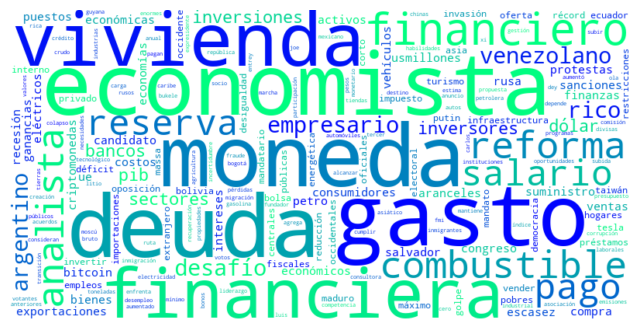

In [ ]:
# 5 частотные экономические слова из частотных слов всего корпуса
counter_no_stop = FreqDist(tokens_no_stop)
freq_all = counter_no_stop.most_common(1000)
counter_no_stop_tokens = []
counter_econ_no_stop = FreqDist(econ_tokens_no_stop)
econ_freq_all = counter_econ_no_stop.most_common(1000)
counter_econ_no_stop_tokens = []

for i in range(len(freq_all)):
    add = freq_all[i][0]
    counter_no_stop_tokens.append(add)
    
for i in range(len(econ_freq_all)):
    add_econ = econ_freq_all[i][0]
    counter_econ_no_stop_tokens.append(add_econ)

uniq_econ_freq_words = []
for i in range(len(counter_econ_no_stop_tokens)):
    if counter_econ_no_stop_tokens[i] not in counter_no_stop_tokens:
        uniq_econ_freq_words.append(counter_econ_no_stop_tokens[i])
        
print(len(uniq_econ_freq_words), uniq_econ_freq_words)
wordcloud = WordCloud(background_color='white', colormap = 'winter', width=800, height=400, random_state=21, max_font_size=110).generate(' '.join(uniq_econ_freq_words))
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

48192


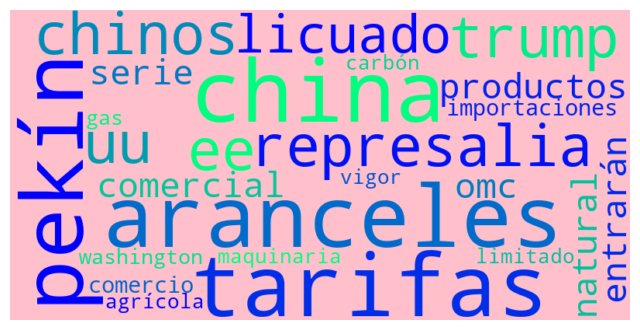

In [ ]:
# 6 всё количество и топ-25 ключевых слов в экономических новостях на основании TF-IDF 

with open('econ_section.txt', 'r') as file:
    econ_raw_text = file.read()

econ_raw_text = econ_raw_text.split('©')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1)) 
X = tfidf_vectorizer.fit_transform(econ_raw_text)
text_vector = pd.DataFrame(columns = tfidf_vectorizer.get_feature_names_out(), data = X.toarray()) 
lemmas = list(text_vector.columns)
tf_idf = text_vector.loc[0].tolist()
lemmas_tf_idf = list(zip(lemmas, tf_idf))
sorted_econ_list = sorted(lemmas_tf_idf, key=lambda x: x[1], reverse = True)
print(len(sorted_econ_list))

result = []
for i in range(len(sorted_econ_list)):
    result.append(sorted_econ_list[i][0])
    
result_no_stop_tfidf = []
for item in result:
    if item not in all_stopwords:
        result_no_stop_tfidf.append(item)

wordcloud = WordCloud(background_color='pink', colormap = 'winter', width=800, height=400, random_state=21, max_font_size=110).generate(' '.join(result_no_stop_tfidf[:25]))
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
# 7.1 экономические тексты: смотрим процент (относительную частоту) слов из учебного глоссария СПЕЦтерминов в экономическом новостном корпусе
with open('words_cervantes.txt', 'r', encoding='UTF-16LE') as file:
    words_cervantes = file.read()
    
words_cervantes = words_cervantes.split()

# парсинг глоссария выполнен в скрипте 'vocab_cervantes.ipynb', его результат записан в файле 'words_cervantes.txt' -- 15605 токенов
print(len(words_cervantes))

# выделяем и подсчитываем токены из учебного глоссария спецтерминов, которые присутствуют в экономическом новостном корпусе
necessary_econ_words = []
for word in words_cervantes:
    if word in econ_tokens_no_stop:
       necessary_econ_words.append(word) 
       
print(len(necessary_econ_words),necessary_econ_words)

# процент слов из учебного глоссария СПЕЦтерминов, которые пригодились для понимания экономических текстов -- 1,7%
print((len(necessary_econ_words)/len(econ_tokens_no_stop)*100),'%')

15605
9163 ['pelo', 'ojo', 'nariz', 'cabeza', 'cara', 'brazo', 'mano', 'dedo', 'pierna', 'pie', 'oído', 'garganta', 'estómago', 'espalda', 'alto', 'gordo', 'delgado', 'feo', 'rubio', 'moreno', 'rubio', 'moreno', 'blanco', 'barba', 'bigote', 'gafas', 'claros', 'oscuros', 'azules', 'verdes', 'negros', 'marrones', 'pequeños', 'pelo', 'rizado', 'corto', 'levantarse', 'ducharse', 'escuchar', 'lavarse', 'andar', 'pasear', 'correr', 'subir', 'bajar', 'sentarse', 'oír', 'coger', 'ejercicio', 'gimnasia', 'deporte', 'sexo', 'nacer', 'crecer', 'morir', 'inteligente', 'trabajador', 'alegre', 'serio', 'tímido', 'sociable', 'optimista', 'abierto', 'reservado', 'tranquilo', 'nervioso', 'generoso', 'egoísta', 'amable', 'agradable', 'triste', 'contento', 'enfadado', 'nervioso', 'preocupado', 'gustar', 'odiar', 'miedo', 'calor', 'frío', 'sueño', 'sed', 'hambre', 'dolor', 'cansado', 'mirar', 'oír', 'escuchar', 'egoísta', 'nombre', 'apellido', 'señor', 'señora', 'señores', 'firmar', 'llamarse', 'dirección

In [32]:
# 7.2 экономические тексты: смотрим процент (относительную частоту) слов из учебного глоссария ОБЩИХ терминов в экономическом новостном корпусе
with open('words_gen_cervantes.txt', 'r', encoding='UTF-16LE') as file:
    words_gen_cervantes = file.read()
words_gen_cervantes = words_gen_cervantes.split()
print(len(words_gen_cervantes))

# выделяем и подсчитываем токены из учебного глоссария общих терминов, которые присутствуют в экономическом новостном корпусе
necessary_econ_gen_words = []
for word in words_gen_cervantes:
    if word in econ_tokens_no_stop:
       necessary_econ_gen_words.append(word) 

print(len(necessary_econ_gen_words), necessary_econ_gen_words)

# процент слов из учебного глоссария ОБЩИХ терминов, которые пригодились для понимания экономических текстов -- 1,1%       
print((len(necessary_econ_gen_words)/len(econ_tokens_no_stop)*100),'%')

13569
6172 ['barrio', 'farmacias', 'aeropuerto', 'piso', 'habitaciones', 'metro', 'calle', 'nacer', 'morir', 'gente', 'azúcar', 'favor', 'leche', 'gracias', 'leche', 'entradas', 'coche', 'blanco', 'hotel', 'grande', 'color', 'color', 'parecido', 'típico', 'material', 'camisa', 'clase', 'jueves', 's', 'probable', 'seguro', 'increíble', 'necesario', 'necesitar', 'suerte', 'número', 'números', 'años', 'ciudad', 'habitantes', 'números', 'vivimos', 'piso', 'gente', 'precio', 's', 's', 'pan', 'favor', 's', 's', 'habitantes', 'dinero', 'botella', 'vaso', 'paquete', 'caja', 'lata', 's', 'número', 'personas', 's', 'gusta', 'tímido', 'demasiado', 'interesa', 'demasiado', 'caro', 's', 'piso', 'bonito', 'grande', 'pequeño', 'grande', 'pequeño', 'corto', 'alto', 'metro', 's', 'kilómetro', 's', 'pido', 'lento', 'despacio', 'entiendo', 's', 'despacio', 'favor', 'delgado', 'gordo', 'grande', 'pequeño', 'parque', 'grande', 'caliente', 'frío', 'café', 'frío', 'frío', 'calor', 'talla', 'talla', 'grande',

In [33]:
# 7.3 экономические тексты: смотрим процент (относительную частоту) слов из объединенного учебного глоссария (спец и общие термины) в экономическом новостном корпусе
with open('all_words_cervantes.txt', 'r', encoding='UTF-16LE') as file:
    all_words_cervantes = file.read()

all_words_cervantes = all_words_cervantes.split()
print(len(all_words_cervantes))

# выделяем и подсчитываем токены из объединенного учебного глоссария, которые присутствуют в экономическом новостном корпусе
necessary_all_words = []
for word in all_words_cervantes:
    if word in econ_tokens_no_stop:
       necessary_all_words.append(word) 

print(len(necessary_all_words),necessary_all_words)
       
# процент слов из объединенного учебного глоссария, которые пригодились для понимания экономических текстов -- 2,9% 
print((len(necessary_all_words)/len(econ_tokens_no_stop)*100),'%')

29174
15335 ['pelo', 'ojo', 'nariz', 'cabeza', 'cara', 'brazo', 'mano', 'dedo', 'pierna', 'pie', 'oído', 'garganta', 'estómago', 'espalda', 'alto', 'gordo', 'delgado', 'feo', 'rubio', 'moreno', 'rubio', 'moreno', 'blanco', 'barba', 'bigote', 'gafas', 'claros', 'oscuros', 'azules', 'verdes', 'negros', 'marrones', 'pequeños', 'pelo', 'rizado', 'corto', 'levantarse', 'ducharse', 'escuchar', 'lavarse', 'andar', 'pasear', 'correr', 'subir', 'bajar', 'sentarse', 'oír', 'coger', 'ejercicio', 'gimnasia', 'deporte', 'sexo', 'nacer', 'crecer', 'morir', 'inteligente', 'trabajador', 'alegre', 'serio', 'tímido', 'sociable', 'optimista', 'abierto', 'reservado', 'tranquilo', 'nervioso', 'generoso', 'egoísta', 'amable', 'agradable', 'triste', 'contento', 'enfadado', 'nervioso', 'preocupado', 'gustar', 'odiar', 'miedo', 'calor', 'frío', 'sueño', 'sed', 'hambre', 'dolor', 'cansado', 'mirar', 'oír', 'escuchar', 'egoísta', 'nombre', 'apellido', 'señor', 'señora', 'señores', 'firmar', 'llamarse', 'direcció

In [34]:
# 7.4 все тексты: смотрим процент (относительную частоту) слов из учебного глоссария во всём новостном корпусе -- 0.6%

necessary_allcorpus_words = []
for word in all_words_cervantes:
    if word in tokens_no_stop:
       necessary_allcorpus_words.append(word) 
       
print((len(necessary_allcorpus_words)/len(tokens_no_stop)*100),'%')

0.553220893155648 %
